In [1]:
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybroom as pb
from IPython.display import Math

plt.rcParams["text.usetex"] = True

import plot_function


def TC(x, ystress=1.0, eta_bg=0.1, gammadot_crit=0.1):
    """Three component model
    Note:
    .. math::
       \sigma=\sigma_y+\sigma_y\cdot(\dot\gamma/\dot\gamma_c)^{0.5}+\eta_{bg}\cdot\dot\gamma
    Args:
        ystress: yield stress [Pa]
        eta_bg : Background viscosity [Pa s]
        gammadot_crit : Critical shear rate [1/s]
    Returns:
        stress : Shear Stress, [Pa]
    """
    return ystress + ystress * (x / gammadot_crit) ** 0.5 + eta_bg * x


TC_model = lmfit.Model(TC, prefix="TC_")
""" Lmfit model from equation :meth:`rheofit.models.TC`
Note:
TC_model.set_param_hint('ystress', min=0)
TC_model.set_param_hint('eta_bg', min=0, vary=True)
TC_model.set_param_hint('gammadot_crit', min=0)
"""
TC_model.model_expression = Math(
    "\sigma=\sigma_y+\sigma_y\cdot(\dot\gamma/\dot\gamma_c)^{0.5}+\eta_{bg}\cdot\dot\gamma"
)

TC_model.set_param_hint("ystress", min=0)
TC_model.set_param_hint("eta_bg", min=0, vary=True)
TC_model.set_param_hint("gammadot_crit", min=0)


def HB(x, ystress=1.0, K=1.0, n=0.5):
    """Hershel-Bulkley Model
    Note:
    .. math::
       \sigma= \sigma_y + K \cdot \dot\gamma^n
    Args:
        ystress: yield stress [Pa]
        K : Consistency~index [Pa s^n]
        n : Shear thinning~index []
    Returns:
        stress : Shear Stress, [Pa]
    """
    return ystress + K * x**n


HB_model = lmfit.Model(HB, prefix="HB_")
""" Lmfit model from equation :meth:`rheofit.models.HB`
Note:
HB_model.set_param_hint('ystress', min=0)
HB_model.set_param_hint('K', min=0, vary=True)
HB_model.set_param_hint('n', min=0.0,max=1,vary=True)
"""

HB_model.model_expression = Math("\sigma=\sigma_y+K\cdot\dot\gamma^n")

HB_model.set_param_hint("ystress", min=0)
HB_model.set_param_hint("K", min=0, vary=True)
HB_model.set_param_hint("n", min=0.0, max=1, vary=True)


def make_generator(iterable):
   ~index = 0
    while True:
        yield iterable[index]
       ~index += 1

In [2]:
data_fig_6 = pd.read_csv("figure_6.csv", header=[0, 1])
data_fig_9 = pd.read_csv("figure_9.csv", header=[0, 1])

In [3]:
sample_label_list_fig6 = list(data_fig_6.columns.get_level_values(0).unique())
sample_label_list_fig9 = list(data_fig_9.columns.get_level_values(0).unique())

In [30]:
sample_label_dict_fig6 = {
    "G_8pc": "$8\%~\mathrm{Cp~in~glycerin}$",
    "G_5pc": "$5\%~\mathrm{Cp~in~glycerin}$",
    "G_3pc": "$3\%~\mathrm{Cp~in~glycerin}$",
    "PG_8pc": "$8\%~\mathrm{Cp~in~glycerin/PEG}$",
    "PG_5pc": "$5\%~\mathrm{Cp~in~glycerin/PEG}$",
    "PG_3pc": "$3\%~\mathrm{Cp~in~glycerin/PEG}$",
    "P_8pc": "$8\%~\mathrm{Cp~in~PEG}$",
    "P_5pc": "$5\%~\mathrm{Cp~in~PEG}$",
    "P_3pc": "$3\%~\mathrm{Cp~in~PEG}$",
}

sample_label_dict_fig9 = {
    "G_2pcCP": "$2\%~\mathrm{Cp~in~glycerin}$",
    "G_1p5pcCP": "$1.5\%~\mathrm{Cp~in~glycerin}$",
    "G_1pcCP": "$1\%~\mathrm{Cp~in~glycerin}$",
    "PG_2pcCP": "$2\%~\mathrm{Cp~in~glycerin/PEG}$",
    "PG_1p5pcCP": "$1.5\%~\mathrm{Cp~in~glycerin/PEG}$",
    "PG_1pcCP": "$1\%~\mathrm{Cp~in~glycerin/PEG}$",
    "P_2pcCP": "$2\%~\mathrm{Cp~in~PEG}$",
    "P_1p5pcCP": "$1.5\%~\mathrm{Cp~in~PEG}$",
}

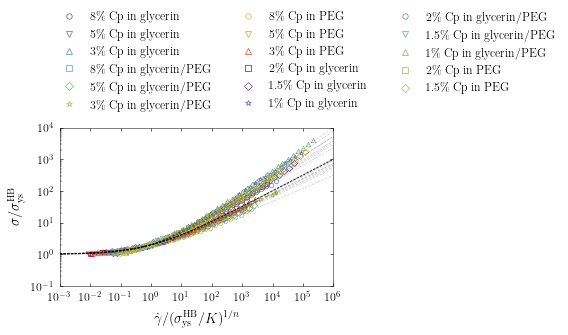

In [40]:
fig, ax, colors, markers = plot_function.create_plot()
fit_res_dict_HB={}

for sample_label in sample_label_list_fig6:
    data = data_fig_6.loc[:, data_fig_6.columns.get_level_values(0) == sample_label][
        sample_label
    ]
    fit = HB_model.fit(data["Y"], x=data["X"], weights=1 / data["Y"], nan_policy="omit")
    fit_res_dict_HB[sample_label]=fit

    x_rescale = (fit.best_values["HB_ystress"] / fit.best_values["HB_K"]) ** (
        1 / fit.best_values["HB_n"]
    )

    ax.plot(
        data["X"] / x_rescale,
        data["Y"] / fit.best_values["HB_ystress"],
        marker=next(markers),
        color=next(colors),
        linestyle="None",
        mfc="None",
        label=sample_label_dict_fig6[sample_label],
    )
    ax.set_yscale("log")
    ax.set_xscale("log")

for sample_label in sample_label_list_fig9:
    data = data_fig_9.loc[:, data_fig_9.columns.get_level_values(0) == sample_label][
        sample_label
    ]
    fit = HB_model.fit(data["Y"], x=data["X"], weights=1 / data["Y"], nan_policy="omit")
    fit_res_dict_HB[sample_label]=fit

    x_rescale = (fit.best_values["HB_ystress"] / fit.best_values["HB_K"]) ** (
        1 / fit.best_values["HB_n"]
    )

    ax.plot(
        data["X"] / x_rescale,
        data["Y"] / fit.best_values["HB_ystress"],
        marker=next(markers),
        color=next(colors),
        linestyle="None",
        mfc="None",
        label=sample_label_dict_fig9[sample_label],
    )
    ax.set_yscale("log")
    ax.set_xscale("log")

fit_res_table_HB=pb.tidy(fit_res_dict_HB).pivot(index='key',columns='name', values='value')    

ax.plot(np.logspace(-3, 8), 1 + np.logspace(-3, 8) ** 0.5, c="k", linestyle='--', marker='')

for n in fit_res_table_HB.HB_n:
    ax.plot(np.logspace(-3, 8), 1 + np.logspace(-3, 8) ** n, color="k", linestyle='--', alpha=0.2, marker='')


ax.set_xlabel("$\dot\gamma / (\sigma_\mathrm{ys}^\mathrm{HB}/K)^{1/n}$")
ax.set_ylabel("$\sigma / \sigma_\mathrm{ys}^\mathrm{HB}$")
ax.legend(bbox_to_anchor=(-0.05, 1.8), loc="upper left", ncol=3)
ax.set_xlim(0.001, 1e6)
ax.set_ylim(0.1, 1e4)
ax.set(xticks=[1e-3, 0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5, 1e6])
fig.savefig("HB mastercurve.svg", bbox_inches="tight")

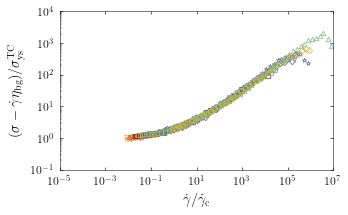

In [29]:
fig, ax, colors, markers = plot_function.create_plot()

for sample_label in sample_label_list_fig6:
    data = data_fig_6.loc[:, data_fig_6.columns.get_level_values(0) == sample_label][
        sample_label
    ]
    fit = TC_model.fit(data["Y"], x=data["X"], weights=1 / data["Y"], nan_policy="omit")

    x_rescale = fit.best_values["TC_gammadot_crit"]

    ax.plot(
        data["X"] / x_rescale,
        (data["Y"] - data["X"] * fit.best_values["TC_eta_bg"])
        / fit.best_values["TC_ystress"],
        marker=next(markers),
        color=next(colors),
        linestyle="None",
        mfc="None",
        label=sample_label_dict_fig6[sample_label],
    )
    ax.set_yscale("log")
    ax.set_xscale("log")

for sample_label in sample_label_list_fig9:
    data = data_fig_9.loc[:, data_fig_9.columns.get_level_values(0) == sample_label][
        sample_label
    ]
    fit = TC_model.fit(data["Y"], x=data["X"], weights=1 / data["Y"], nan_policy="omit")

    x_rescale = fit.best_values["TC_gammadot_crit"]

    ax.plot(
        data["X"] / x_rescale,
        (data["Y"] - data["X"] * fit.best_values["TC_eta_bg"])
        / fit.best_values["TC_ystress"],
        marker=next(markers),
        color=next(colors),
        linestyle="None",
        mfc="None",
        label=sample_label_dict_fig9[sample_label],
    )
    ax.set_yscale("log")
    ax.set_xscale("log")

#ax.plot(np.logspace(-3, 8), 1 + np.logspace(-3, 8) ** 0.5, c="k", ls='--', marker='')

ax.set_xlabel("$\dot \gamma / \dot\gamma_\mathrm{c}$")
ax.set_ylabel("$(\sigma - \dot\gamma \eta_\mathrm{bg}) / \sigma_\mathrm{ys}^\mathrm{TC}$")
ax.set_xlim(1e-5, 1e7)
ax.set_ylim(0.1, 1e4)
#fig.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

fig.savefig("TC mastercurve.svg", bbox_inches="tight")